Obtenemos el dataset de roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ptzxcH0XI4loWLI9VAAb")
project = rf.workspace("my-first-model-3qqjo").project("psoriasis-rtubr-ioewn")
version = project.version(1)
dataset = version.download("voc")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Psoriasis-1 in voc:: 100%|██████████| 2151/2151 [00:00<00:00, 5375.79it/s]


Verifico que se está leyndo correctamente las imagenes en el directorio indicado

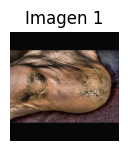

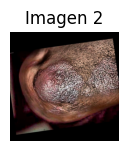

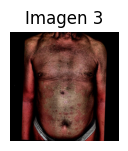

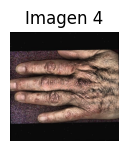

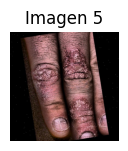

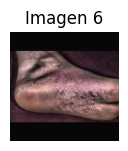

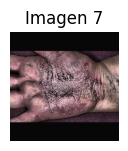

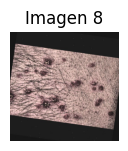

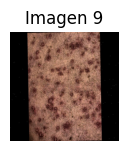

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Muestra algunas imágenes de entrenamiento
for i in range(9):
    # Get a list of files in the directory
    files = os.listdir('/content/Psoriasis-1/train/')
    # Filter out only image files
    image_files = [f for f in files if f.endswith(('.jpg', '.png'))]
    # If the directory is empty, skip this iteration
    if not image_files:
        print(f"Skipping iteration {i}, directory is empty.")
        continue
    img_path = f"/content/Psoriasis-1/train/{image_files[i]}"
    # Print the image path to check if it's correct
    #print(f"Trying to load image from: {img_path}")
    ax = plt.subplot(3, 3, i + 1) # (nrows, ncols, index)
    img = cv2.imread(img_path)
    # Check if the image was loaded successfully
    if img is None:
        print(f"Failed to load image from: {img_path}")
        continue  # Skip to the next iteration if image loading failed
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    plt.imshow(img)
    plt.title(f"Imagen {i+1}")
    plt.axis('off')
    plt.show()

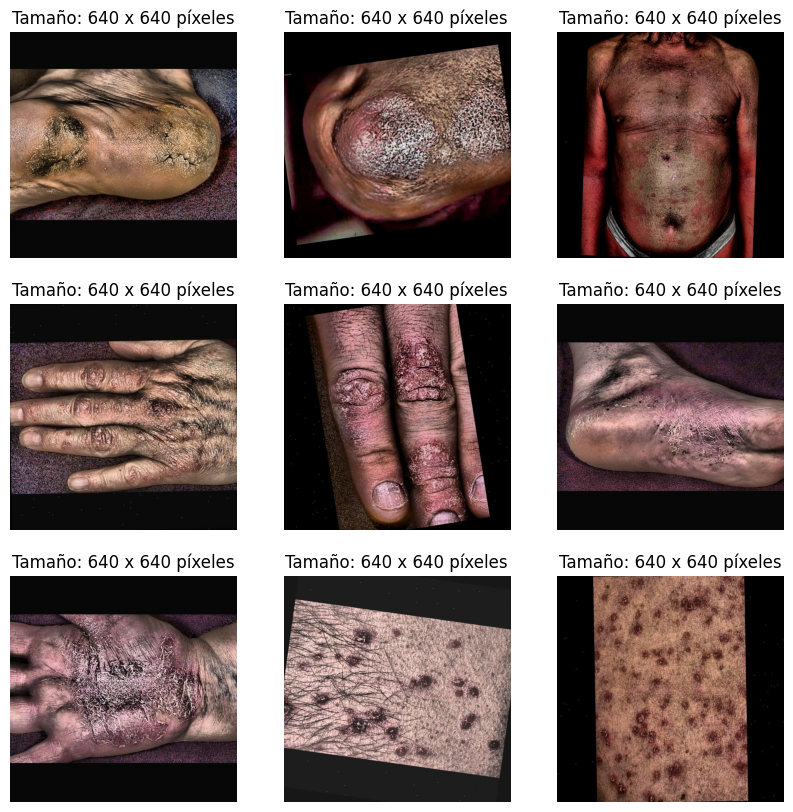

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Muestra algunas imágenes de entrenamiento
plt.figure(figsize=(10, 10))
for i in range(9):
    # Get a list of files in the directory
    files = os.listdir('/content/Psoriasis-1/train/')
    # Filter out only image files
    image_files = [f for f in files if f.endswith(('.jpg', '.png'))]
    # If the directory is empty, skip this iteration
    if not image_files:
        print(f"Skipping iteration {i}, directory is empty.")
        continue

    # Ensure that we don't try to access more images than are available
    if i >= len(image_files):
        break  # Stop the loop if we've reached the end of the image files

    img_path = f"/content/Psoriasis-1/train/{image_files[i]}"
    # Print the image path to check if it's correct
    # print(f"Trying to load image from: {img_path}")
    ax = plt.subplot(3, 3, i + 1)  # (nrows, ncols, index)
    img = cv2.imread(img_path)
    # Check if the image was loaded successfully
    if img is None:
        print(f"Failed to load image from: {img_path}")
        continue  # Skip to the next iteration if image loading failed
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    plt.imshow(img)
    plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} píxeles")
    plt.axis('off')

# Show the plot outside the loop to display all subplots at once
plt.show()

**Preparación de los datos**


In [ ]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

def cargar_datos(split):
    ruta = os.path.join(dataset.location, split)
    imagenes = []
    etiquetas = []

    for archivo in os.listdir(ruta):
        if archivo.endswith(".xml"):  # Filtramos solo los archivos de anotaciones
            xml_path = os.path.join(ruta, archivo)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Obtener el nombre del archivo de imagen asociado
            nombre_imagen = root.find("filename").text
            imagen_path = os.path.join(ruta, nombre_imagen)

            if os.path.exists(imagen_path):  # Aseguramos que la imagen exista
                imagen = cv2.imread(imagen_path)
                imagen = cv2.resize(imagen, (640, 640))  # Redimensionar según necesites
                imagenes.append(imagen)

                # Obtener la etiqueta (nombre de la clase)
                etiqueta = root.find("object").find("name").text
                etiquetas.append(etiqueta)

    return np.array(imagenes), np.array(etiquetas)

# Cargamos los datos
X_train, y_train = cargar_datos("train")
X_valid, y_valid = cargar_datos("valid")
X_test, y_test = cargar_datos("test")

print("Datos de entrenamiento:", X_train.shape, y_train.shape)
print("Datos de validación:", X_valid.shape, y_valid.shape)
print("Datos de prueba:", X_test.shape, y_test.shape)


Datos de entrenamiento: (939, 640, 640, 3) (939,)
Datos de validación: (89, 640, 640, 3) (89,)
Datos de prueba: (45, 640, 640, 3) (45,)


Realizamos data augmentation con tensorflow y preparamos nuestro dataset para el entrenamiento


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

def prepare_data_with_augmentation():
    # Load original data
    X_train, y_train = cargar_datos("train")
    X_valid, y_valid = cargar_datos("valid")
    X_test, y_test = cargar_datos("test")

    # Normalize images
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0
    X_test = X_test / 255.0

    # Convert labels to numerical using LabelEncoder
    encoder = LabelEncoder()
    all_labels = np.concatenate([y_train, y_valid, y_test])
    encoder.fit(all_labels)
    y_train_encoded = encoder.transform(y_train)
    y_valid_encoded = encoder.transform(y_valid)
    y_test_encoded = encoder.transform(y_test)

    # Convert to categorical (one-hot encoding) if necessary
    y_train_cat = tf.keras.utils.to_categorical(y_train_encoded, num_classes=len(encoder.classes_))
    y_valid_cat = tf.keras.utils.to_categorical(y_valid_encoded, num_classes=len(encoder.classes_))
    y_test_cat = tf.keras.utils.to_categorical(y_test_encoded, num_classes=len(encoder.classes_))

    # Data augmentation for training set (if needed)
    data_augmentation = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = data_augmentation.flow(
        X_train, y_train_cat,
        batch_size=32
    )

    # Validation and test data (no augmentation)
    validation_data = (X_valid, y_valid_cat)
    test_data = (X_test, y_test_cat)

    return train_generator, validation_data, test_data, encoder.classes_

Modelo **ResNet** usado para la clasificacion de imágenes:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam


def create_resnet_model(input_shape, num_classes):
    """
    Creates a ResNet-based model for image classification.

    Args:
        input_shape: Tuple specifying the input image shape (height, width, channels).
        num_classes: Number of classes for classification.

    Returns:
        A Keras model instance.
    """

    # Load pre-trained ResNet50 model (without the classification layer)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze most layers but allow the last convolutional block to be trained
    for layer in base_model.layers[:-50]:  # Freeze all but the last 50 layers modificable
        layer.trainable = False
    for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
        layer.trainable = True


    # Add custom classification layers on top of the base model
    inputs = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)  # Batch normalization for better training
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))(x) # L2 regularization. modificable
    x = layers.BatchNormalization()(x)  # Batch normalization for better training
    x = layers.Dropout(0.8)(x)  # Dropout to reduce overfitting modificable
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Example usage:
input_shape = (640, 640, 3)  # Adjust according to your image size
num_classes = 5  # Adjust according to your number of classes

model = create_resnet_model(input_shape, num_classes)

# Compile the model

learning_rate = 2e-5  # Tiempo de aprendizaje, mientra más bajo mejor pero más lento aprende.
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
# model.summary()

# Convert string labels to numerical using LabelEncoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_valid_encoded = encoder.transform(y_valid)

# Convert numerical labels to one-hot encoded format
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_valid_categorical = to_categorical(y_valid_encoded, num_classes=num_classes)

# Train the model using the encoded labels
history = model.fit(X_train, y_train_categorical, epochs=40, validation_data=(X_valid, y_valid_categorical))

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.2159 - loss: 4.5152 - val_accuracy: 0.2921 - val_loss: 2.7133
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 921ms/step - accuracy: 0.2795 - loss: 3.8243 - val_accuracy: 0.3820 - val_loss: 2.5589
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 927ms/step - accuracy: 0.3426 - loss: 3.3790 - val_accuracy: 0.4045 - val_loss: 2.4418
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 905ms/step - accuracy: 0.4219 - loss: 3.1491 - val_accuracy: 0.4831 - val_loss: 2.3441
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 902ms/step - accuracy: 0.5073 - loss: 2.6938 - val_accuracy: 0.5506 - val_loss: 2.2712
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 890ms/step - accuracy: 0.5369 - loss: 2.4976 - val_accuracy: 0.5281 - val_loss: 2.2205
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 951ms/step - accuracy: 0.5675 - loss: 2.5154 - val_accuracy: 0.5393 - val_loss: 2.1737
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 889ms/step - accuracy: 0.5894 - loss: 2.4018 - val_accura

Guardamos el modelo en mi google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Para reanudar el entrenamiento más tarde, cargamos el modelo guardado:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

model = tf.keras.models.load_model('/content/drive/MyDrive/Psoriasis_Classification/trained_resnet_model_v3.h5')

input_shape = (640, 640, 3)  # Adjust according to your image size
num_classes = 5  # Adjust according to your number of classes

# Compile the model

learning_rate = 1e-5  # Adjust according to your needs
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
# model.summary()

# Convert string labels to numerical using LabelEncoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_valid_encoded = encoder.transform(y_valid)

# Convert numerical labels to one-hot encoded format
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_valid_categorical = to_categorical(y_valid_encoded, num_classes=num_classes)

# Train the model using the encoded labels
history = model.fit(X_train, y_train_categorical, epochs=3, validation_data=(X_valid, y_valid_categorical))


Epoch 1/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9843 - loss: 0.5096 - val_accuracy: 0.7416 - val_loss: 1.6780
Epoch 2/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 58s 873ms/step - accuracy: 0.9860 - loss: 0.5011 - val_accuracy: 0.7416 - val_loss: 1.7204
Epoch 3/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 875ms/step - accuracy: 0.9835 - loss: 0.4987 - val_accuracy: 0.7640 - val_loss: 1.7564


In [ ]:
model.save('/content/drive/MyDrive/Psoriasis_Classification/trained_resnet_model_v3.h5')

Cargamos el modelo entrenado:

In [ ]:
from tensorflow.keras.models import load_model

#modelo = load_model('/content/drive/MyDrive/Psoriasis_Classification/trained_resnet_modelv1.h5')  # Reemplaza con la ruta de tu modelo

 Visualiza los resultados

In [ ]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_valid), axis=1)
print(classification_report(y_valid_encoded, y_pred, target_names=encoder.classes_))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step
                         precision    recall  f1-score   support

Psoriasis Eritrodermica       0.75      0.79      0.77        19
      Psoriasis Guttata       0.67      0.67      0.67         9
      Psoriasis Inversa       1.00      0.83      0.91        12
    Psoriasis Pustulosa       0.79      0.50      0.61        22
       Psoriasis Vulgar       0.64      0.85      0.73        27

               accuracy                           0.73        89
              macro avg       0.77      0.73      0.74        89
           weighted avg       0.75      0.73      0.73        89



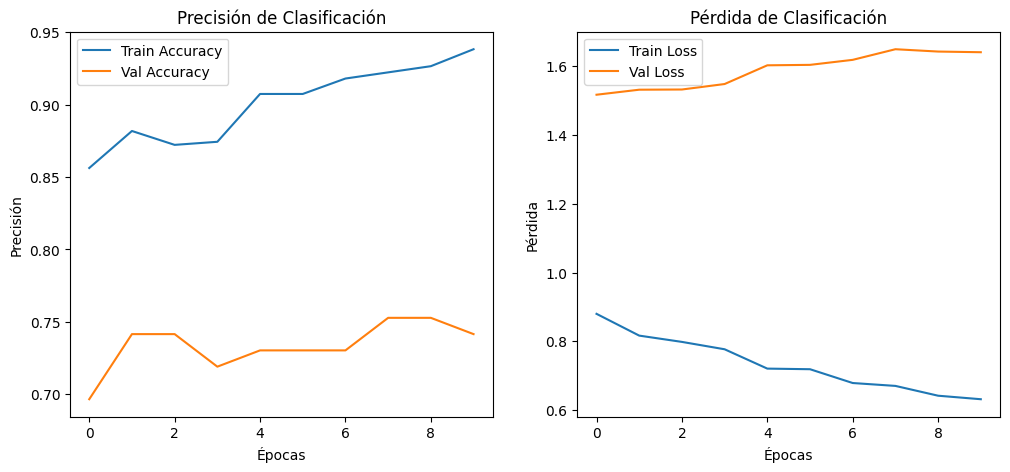

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Precisión de Clasificación")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdida de Clasificación")
plt.legend()

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


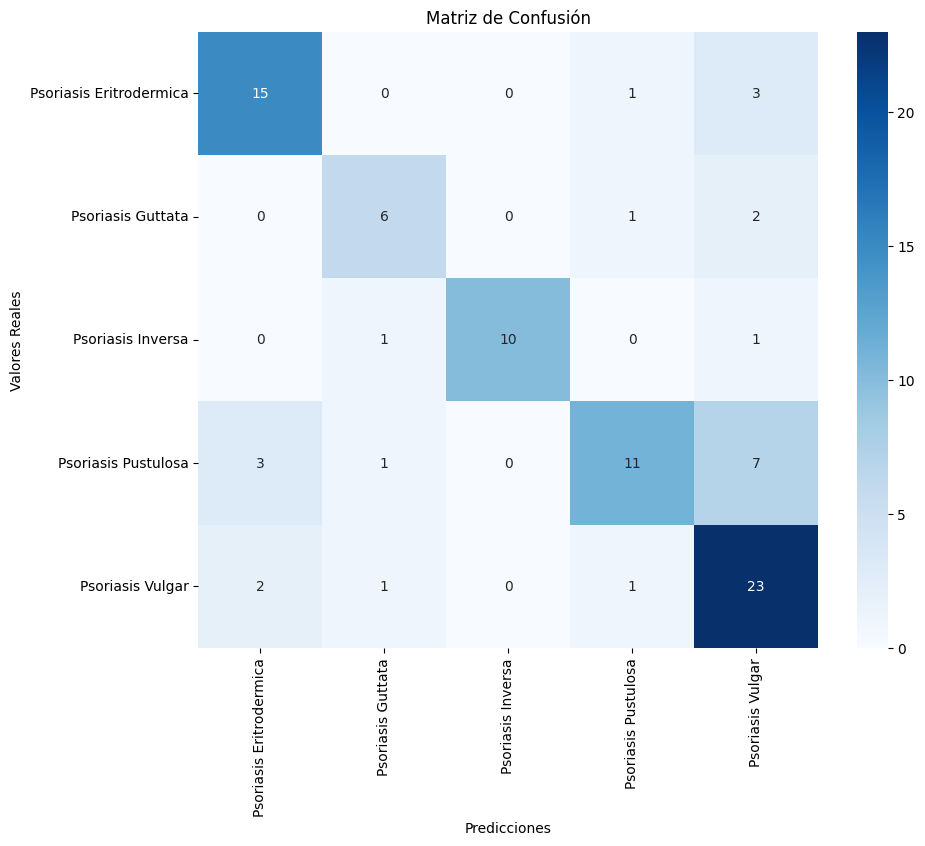

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtén las predicciones del modelo para el conjunto de validación
y_pred = np.argmax(model.predict(X_valid), axis=1)

# Crea la matriz de confusión
cm = confusion_matrix(y_valid_encoded, y_pred)

# Define las etiquetas de las clases
class_names = encoder.classes_

# Crea la figura y los ejes
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Configura los títulos y etiquetas de los ejes
ax.set_title("Matriz de Confusión")
ax.set_xlabel("Predicciones")
ax.set_ylabel("Valores Reales")

# Muestra el gráfico
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


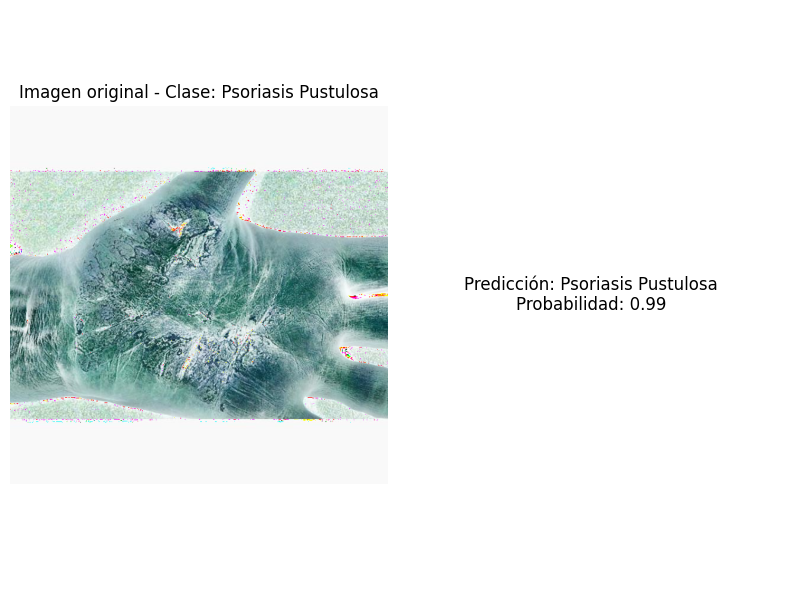

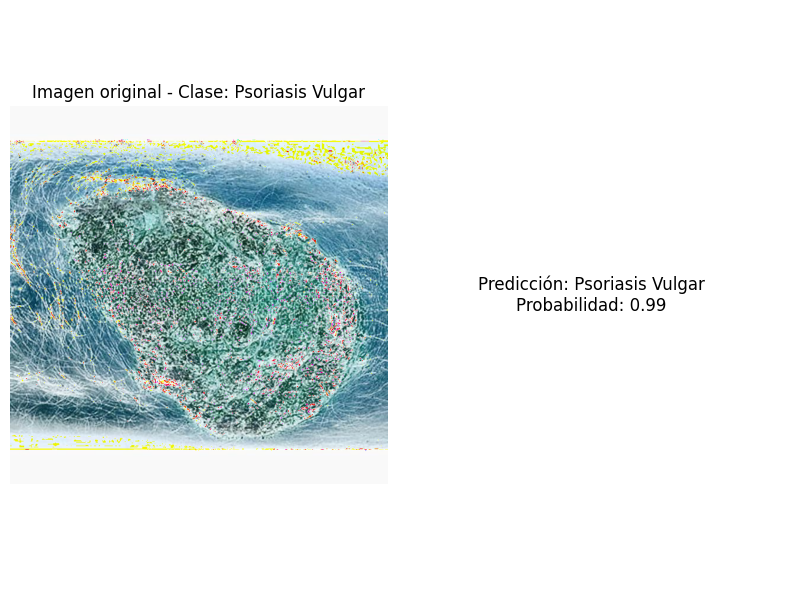

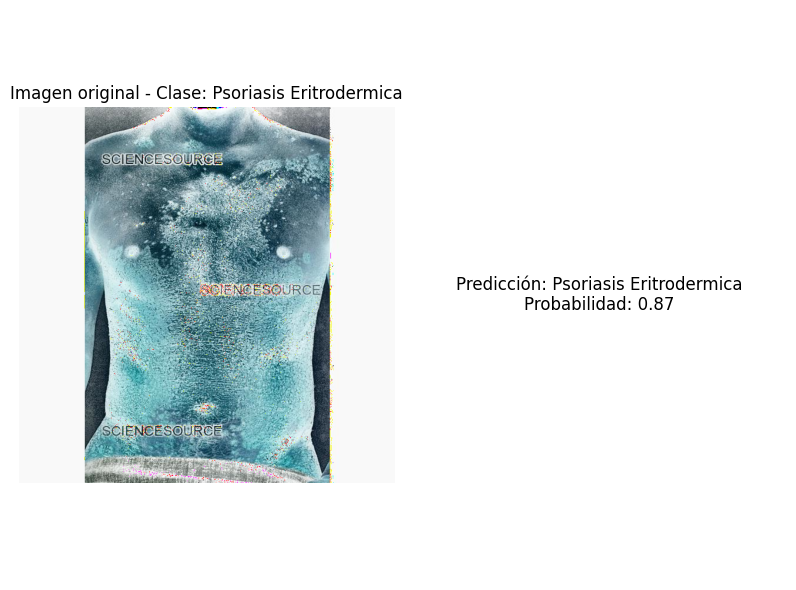

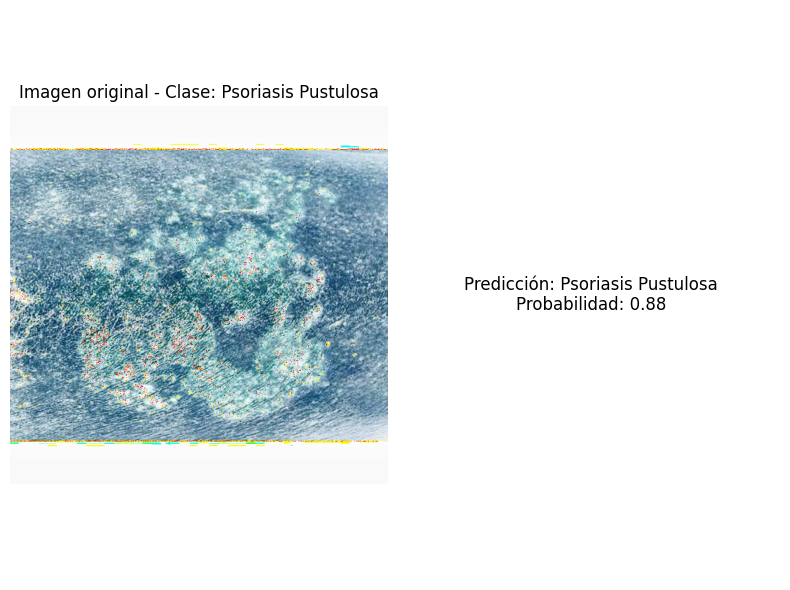

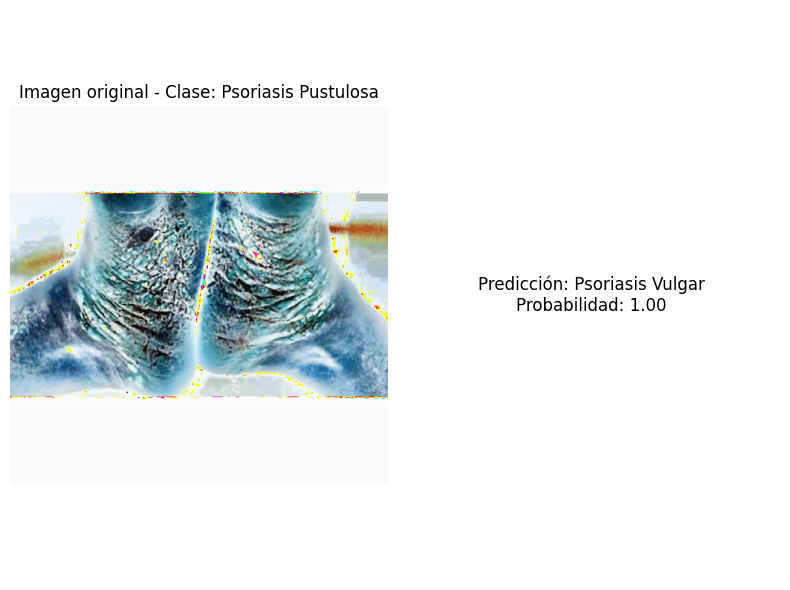

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Número de imágenes a predecir
num_images = 5

# Selecciona imágenes aleatorias del conjunto de validación
random_indices = random.sample(range(len(X_valid)), num_images)
random_images = X_valid[random_indices]
random_labels = y_valid_encoded[random_indices]  # Assuming y_valid_encoded is defined

# Realiza las predicciones
predictions = model.predict(random_images)

# Muestra las imágenes y las predicciones
for i in range(num_images):
    # Obtiene la clase predicha y la probabilidad
    predicted_class = np.argmax(predictions[i])
    probability = predictions[i][predicted_class]

    # Obtiene el nombre de la clase real y predicha
    actual_class_name = encoder.inverse_transform([random_labels[i]])[0]
    predicted_class_name = encoder.inverse_transform([predicted_class])[0]

    # Muestra la imagen original
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)  # Create a subplot for the original image
    imagen_original_uint8 = (random_images[i] * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor((random_images[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f"Imagen original - Clase: {actual_class_name}")
    plt.axis('off')

    # Crea una figura para la predicción
    plt.subplot(1, 2, 2)  # Create a subplot for the prediction
    plt.text(0.5, 0.5, f"Predicción: {predicted_class_name}\nProbabilidad: {probability:.2f}",
             horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')  # Hide axes for the prediction plot
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


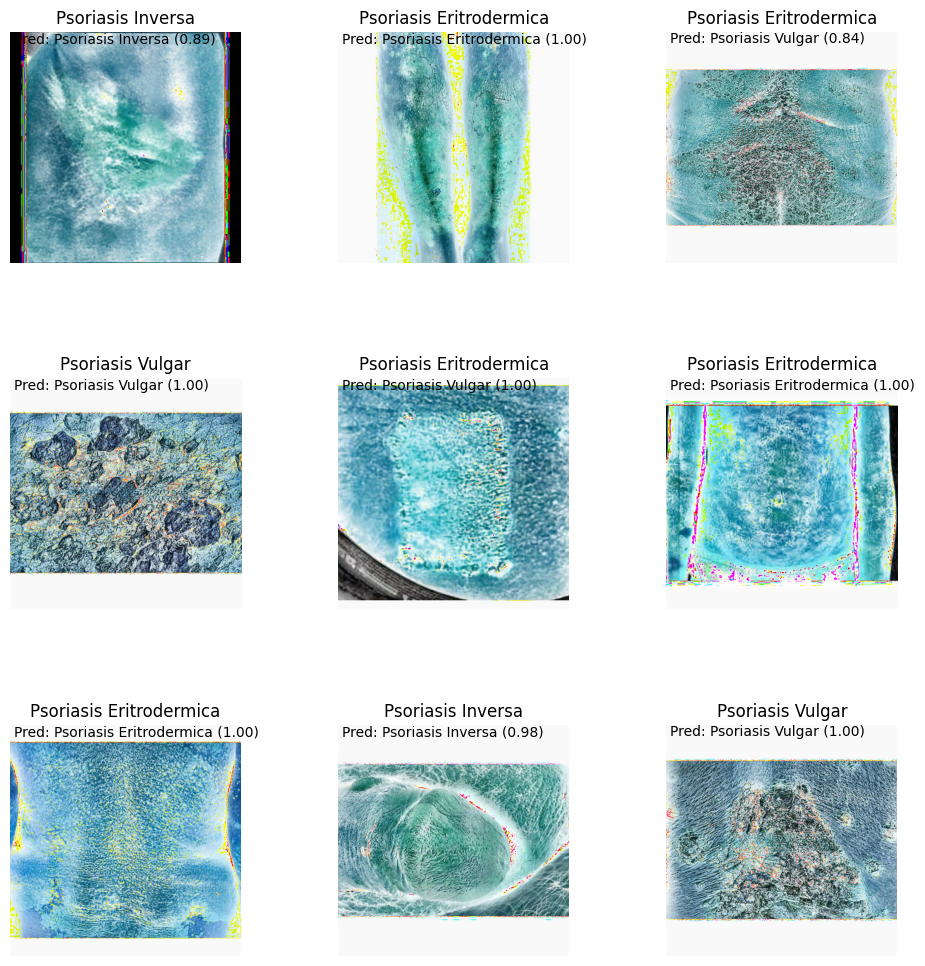

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Número de imágenes a predecir
num_images = 9  # Changed to 9 for a 3x3 grid

# Selecciona imágenes aleatorias del conjunto de validación
random_indices = random.sample(range(len(X_valid)), num_images)
random_images = X_valid[random_indices]
random_labels = y_valid_encoded[random_indices]

# Realiza las predicciones
predictions = model.predict(random_images)

# Muestra las imágenes y las predicciones en una matriz 3x3
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Create a 3x3 grid of subplots
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

for i, ax in enumerate(axes.flat):
    # Obtiene la clase predicha y la probabilidad
    predicted_class = np.argmax(predictions[i])
    probability = predictions[i][predicted_class]

    # Obtiene el nombre de la clase real y predicha
    actual_class_name = encoder.inverse_transform([random_labels[i]])[0]
    predicted_class_name = encoder.inverse_transform([predicted_class])[0]

    # Muestra la imagen
    ax.imshow(cv2.cvtColor((random_images[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    ax.set_title(f"{actual_class_name}")  # Title as actual class
    # Agrega la predicción y probabilidad como texto dentro de la imagen
    ax.text(10, 30, f"Pred: {predicted_class_name} ({probability:.2f})")
    ax.axis('off')

plt.show()